# Step 1: Install Required Libraries

In [1]:
!pip install split-folders tensorflow matplotlib

# Step 2: Import Libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import splitfolders

# Step 3: Prepare and Split Dataset

In [3]:
# Path to your dataset
data_path = r"C:\Users\vudda\OneDrive\Desktop\data"

# Split into train/val/test
splitfolders.ratio(data_path, output="dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 7581 files [01:28, 85.30 files/s] 


# Step 4: Create Image Datasets

Found 6059 files belonging to 16 classes.
Found 752 files belonging to 16 classes.
Found 770 files belonging to 16 classes.


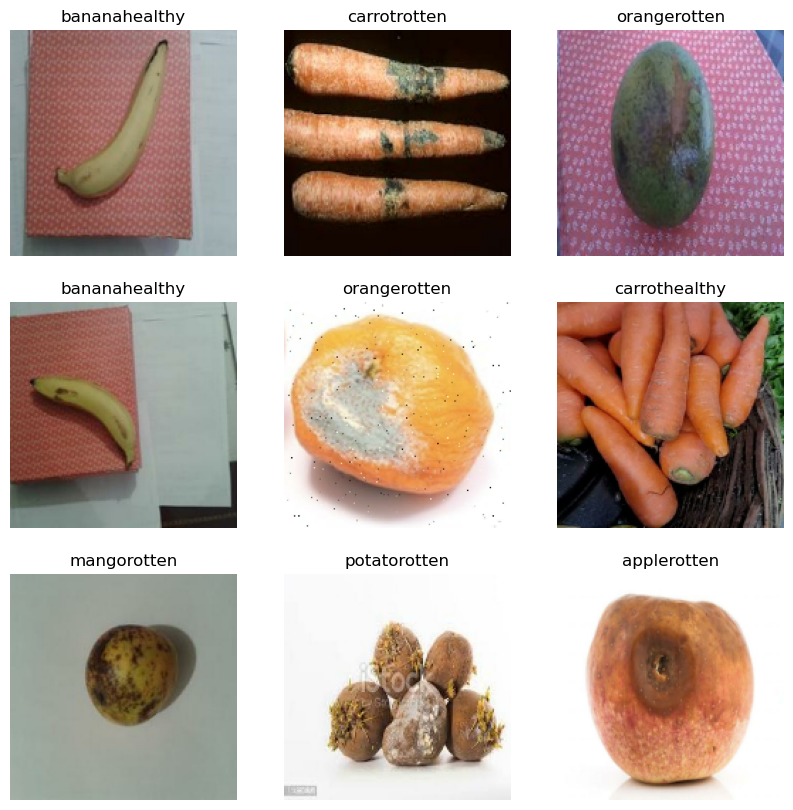

In [4]:
train_dir = "dataset/train"
validation_dir = "dataset/val"
test_dir = "dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

class_names = train_dataset.class_names

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Step 5: Optimize with Prefetching

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Step 6: EfficientNetB4 Model

In [6]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)

base_model_b4 = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')
base_model_b4.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model_b4(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='sigmoid')(x)
model_b4 = tf.keras.Model(inputs, outputs)

model_b4.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

initial_epochs = 6
model_b4.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 183s 865ms/step - accuracy: 0.6355 - loss: 1.3796 - val_accuracy: 0.8657 - val_loss: 0.4449
Epoch 2/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 164s 865ms/step - accuracy: 0.8794 - loss: 0.4192 - val_accuracy: 0.8923 - val_loss: 0.3396
Epoch 3/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 162s 852ms/step - accuracy: 0.9135 - loss: 0.3005 - val_accuracy: 0.9043 - val_loss: 0.2948
Epoch 4/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 162s 851ms/step - accuracy: 0.9264 - loss: 0.2576 - val_accuracy: 0.9109 - val_loss: 0.2720
Epoch 5/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 162s 850ms/step - accuracy: 0.9424 - loss: 0.2164 - val_accuracy: 0.9122 - val_loss: 0.2607
Epoch 6/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 163s 855ms/step - accuracy: 0.9449 - loss: 0.1907 - val_accuracy: 0.9149 - val_loss: 0.2479


In [7]:
# Fine-tune EfficientNetB4
base_model_b4.trainable = True
fine_tune_at_b4 = 100
for layer in base_model_b4.layers[:fine_tune_at_b4]:
    layer.trainable = False

model_b4.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

history_b4_fine = model_b4.fit(train_dataset,
                               epochs=initial_epochs + 10,
                               initial_epoch=initial_epochs,
                               validation_data=validation_dataset)

Epoch 7/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - accuracy: 0.6857 - loss: 0.9921 - val_accuracy: 0.8750 - val_loss: 0.4337
Epoch 8/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.8405 - loss: 0.5670 - val_accuracy: 0.8723 - val_loss: 0.4270
Epoch 9/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.8853 - loss: 0.3990 - val_accuracy: 0.8936 - val_loss: 0.3690
Epoch 10/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.9037 - loss: 0.3195 - val_accuracy: 0.9056 - val_loss: 0.3261
Epoch 11/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9250 - loss: 0.2561 - val_accuracy: 0.9149 - val_loss: 0.2960
Epoch 12/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9388 - loss: 0.2176 - val_accuracy: 0.9189 - val_loss: 0.2694
Epoch 13/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.9501 - loss: 0.1750 - val_accuracy: 0.9215 - val_loss: 0.2510
Epoch 14/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9575 - loss: 0.1485 - val

# Step 7: ResNet50 Model

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

resnet_base = ResNet50(input_shape=IMG_SHAPE,
                       include_top=False,
                       weights='imagenet')
resnet_base.trainable = False

resnet_inputs = tf.keras.Input(shape=IMG_SHAPE)
x = resnet_preprocess(resnet_inputs)
x = resnet_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
resnet_outputs = tf.keras.layers.Dense(len(class_names), activation='sigmoid')(x)
resnet_model = tf.keras.Model(resnet_inputs, resnet_outputs)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

resnet_model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 726ms/step - accuracy: 0.6389 - loss: 1.2255 - val_accuracy: 0.9242 - val_loss: 0.2659
Epoch 2/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 137s 719ms/step - accuracy: 0.9259 - loss: 0.2340 - val_accuracy: 0.9335 - val_loss: 0.2282
Epoch 3/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 138s 727ms/step - accuracy: 0.9554 - loss: 0.1432 - val_accuracy: 0.9455 - val_loss: 0.2117
Epoch 4/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 747ms/step - accuracy: 0.9708 - loss: 0.0946 - val_accuracy: 0.9481 - val_loss: 0.1867
Epoch 5/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 746ms/step - accuracy: 0.9776 - loss: 0.0724 - val_accuracy: 0.9561 - val_loss: 0.1850
Epoch 6/6
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 747ms/step - accuracy: 0.9842 - loss: 0.0580 - val_accuracy: 0.9535 - val_loss: 0.1795


In [9]:
# Fine-tune ResNet50
resnet_base.trainable = True
fine_tune_at_resnet = 100
for layer in resnet_base.layers[:fine_tune_at_resnet]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

resnet_history_fine = resnet_model.fit(train_dataset,
                                       epochs=initial_epochs + 10,
                                       initial_epoch=initial_epochs,
                                       validation_data=validation_dataset)

Epoch 7/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.9349 - loss: 0.2069 - val_accuracy: 0.9548 - val_loss: 0.1653
Epoch 8/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9879 - loss: 0.0595 - val_accuracy: 0.9574 - val_loss: 0.1617
Epoch 9/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9940 - loss: 0.0362 - val_accuracy: 0.9521 - val_loss: 0.1626
Epoch 10/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9952 - loss: 0.0231 - val_accuracy: 0.9588 - val_loss: 0.1548
Epoch 11/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.9980 - loss: 0.0159 - val_accuracy: 0.9588 - val_loss: 0.1540
Epoch 12/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9982 - loss: 0.0135 - val_accuracy: 0.9574 - val_loss: 0.1562
Epoch 13/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9987 - loss: 0.0105 - val_accuracy: 0.9601 - val_loss: 0.1567
Epoch 14/16
190/190 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9996 - loss: 0.0082 - val

# Step 8: Evaluate and Compare Models

In [10]:
loss_b4, accuracy_b4 = model_b4.evaluate(test_dataset)
loss_resnet, accuracy_resnet = resnet_model.evaluate(test_dataset)

print(f"EfficientNetB4 Test Accuracy: {accuracy_b4 * 100:.2f}%")
print(f"ResNet50 Test Accuracy: {accuracy_resnet * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 773ms/step - accuracy: 0.9245 - loss: 0.2403
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - accuracy: 0.9608 - loss: 0.1408
EfficientNetB4 Test Accuracy: 92.99%
ResNet50 Test Accuracy: 95.97%


# Step 9: Plot Accuracy Comparison

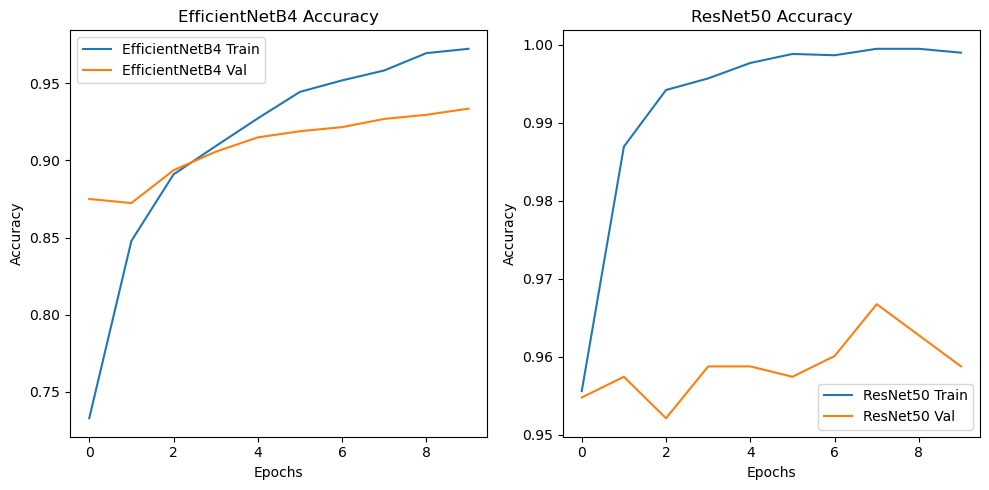

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_b4_fine.history['accuracy'], label='EfficientNetB4 Train')
plt.plot(history_b4_fine.history['val_accuracy'], label='EfficientNetB4 Val')
plt.title("EfficientNetB4 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history_fine.history['accuracy'], label='ResNet50 Train')
plt.plot(resnet_history_fine.history['val_accuracy'], label='ResNet50 Val')
plt.title("ResNet50 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect true and predicted labels
true_labels = []
preds_resnet = []
preds_b4 = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    preds_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))
    preds_b4.extend(np.argmax(model_b4.predict(images), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739

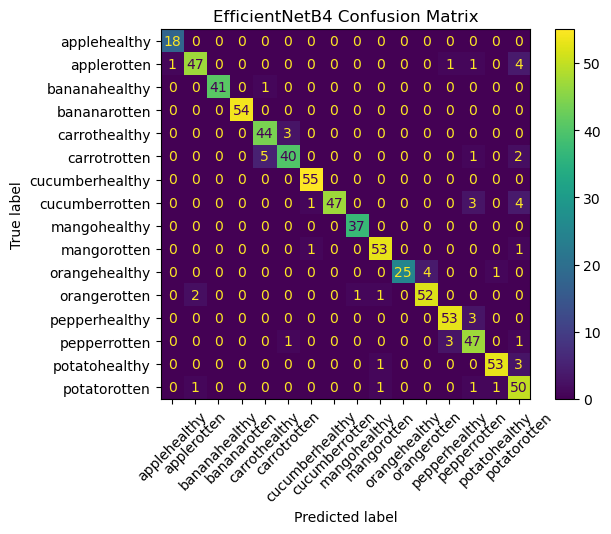

In [13]:
# Confusion Matrix for EfficientNetB4
cm_b4 = confusion_matrix(true_labels, preds_b4)
disp_b4 = ConfusionMatrixDisplay(confusion_matrix=cm_b4, display_labels=class_names)
disp_b4.plot(xticks_rotation=45)
plt.title("EfficientNetB4 Confusion Matrix")
plt.show()

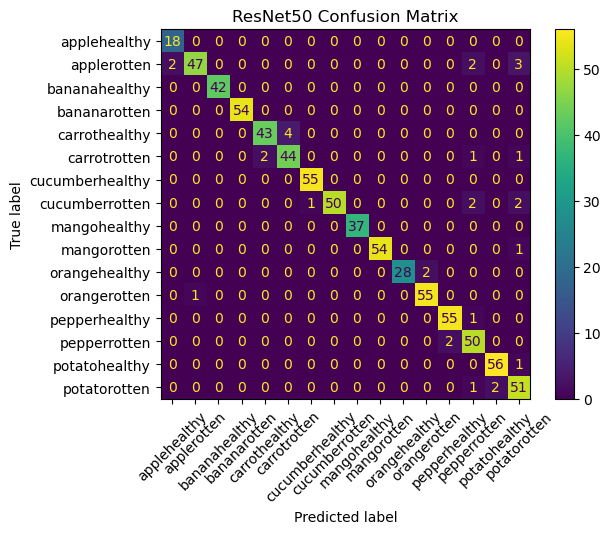

In [14]:
# Confusion Matrix for ResNet50
cm_resnet = confusion_matrix(true_labels, preds_resnet)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_names)
disp_resnet.plot(xticks_rotation=45)
plt.title("ResNet50 Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


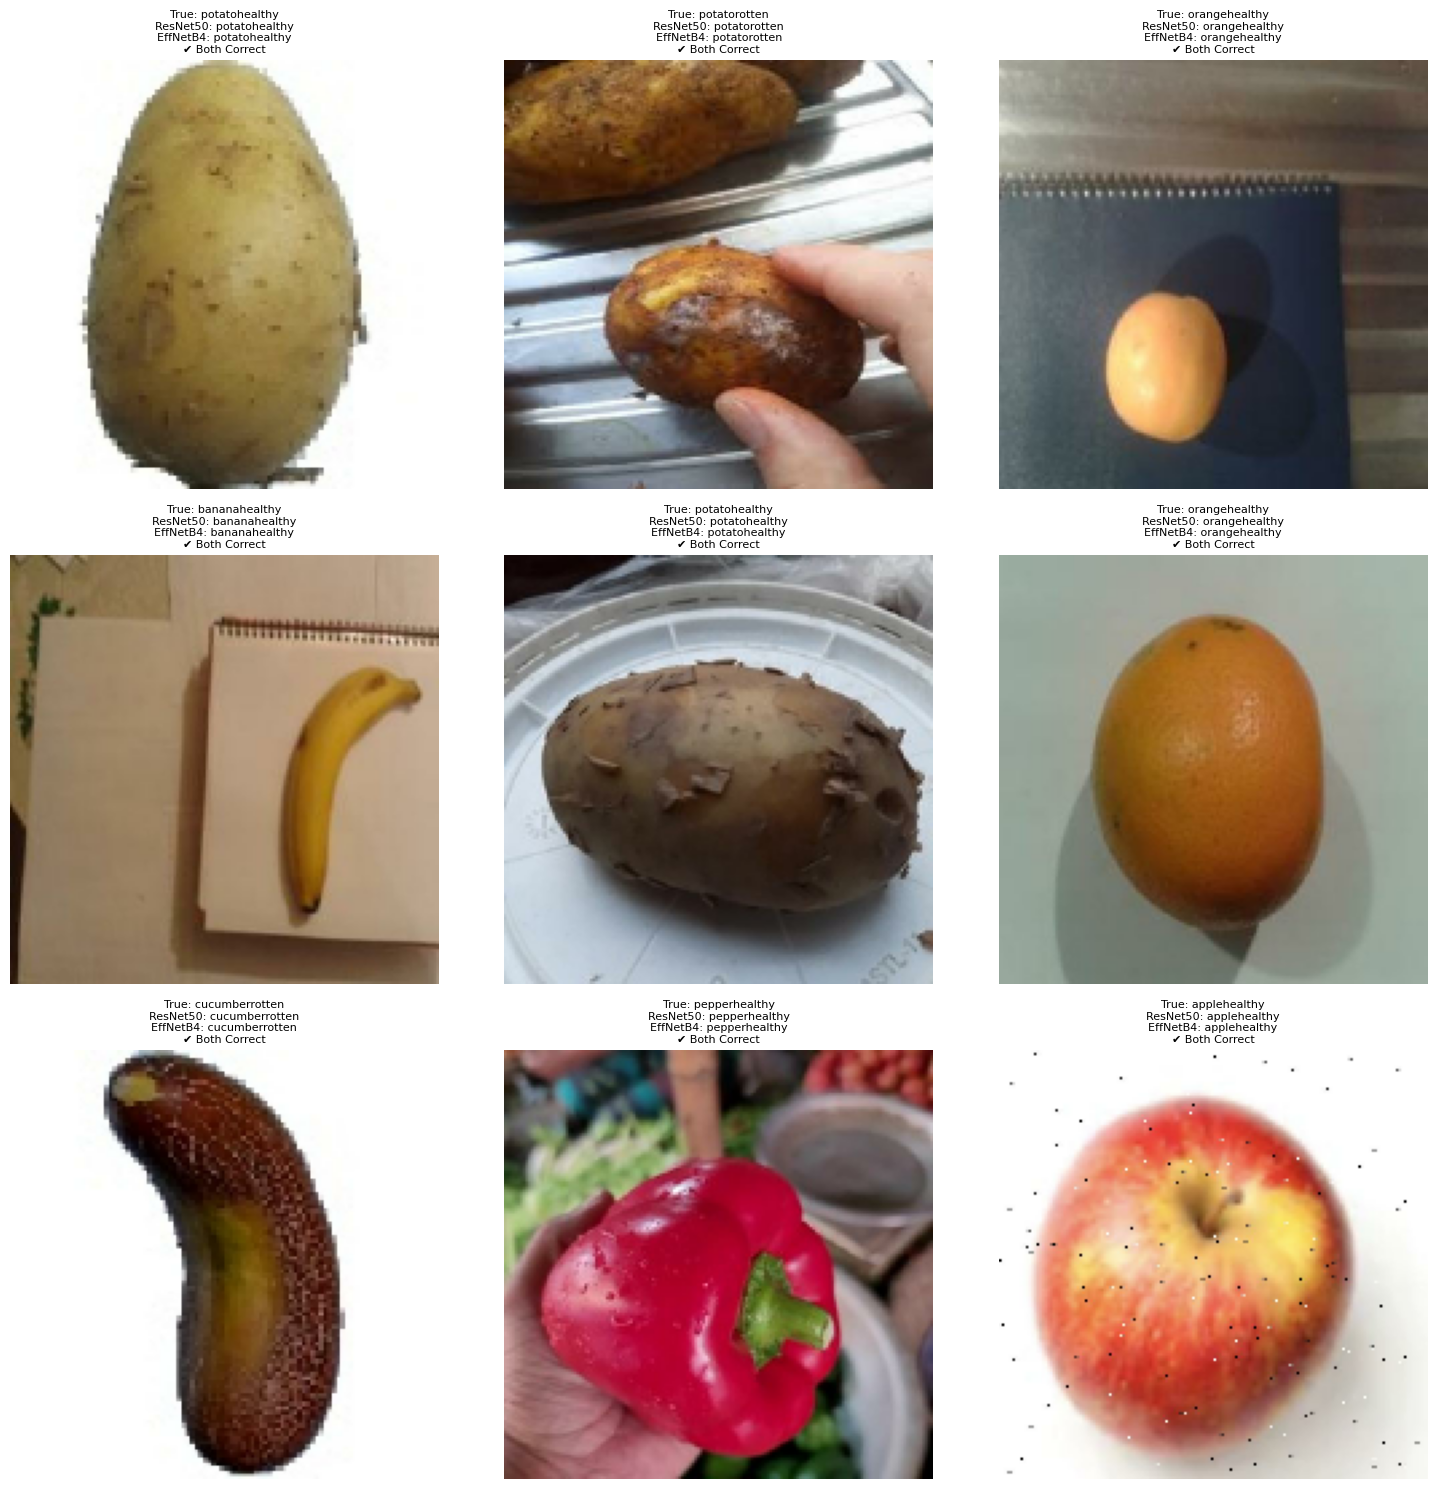

In [20]:
# Get a batch of test images and labels
for test_images, test_labels in test_dataset.take(1):
    preds_b4 = model_b4.predict(test_images)
    preds_resnet = resnet_model.predict(test_images)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i].numpy().astype("uint8"))
        
        true_label = class_names[test_labels[i]]
        pred_b4 = class_names[np.argmax(preds_b4[i])]
        pred_resnet = class_names[np.argmax(preds_resnet[i])]
        
        title = f"True: {true_label}\nResNet50: {pred_resnet}\nEffNetB4: {pred_b4}"
        if pred_resnet == true_label and pred_b4 != true_label:
            title += "\n✔ ResNet better"
        elif pred_b4 == true_label and pred_resnet != true_label:
            title += "\n✔ EffNetB4 better"
        elif pred_b4 == pred_resnet == true_label:
            title += "\n✔ Both Correct"
        else:
            title += "\n✘ Both Wrong"

        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()